In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from importlib import reload
from matplotlib import cm
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import (make_scorer, roc_auc_score, 
                             classification_report, 
                             precision_recall_curve,
                             roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from xgboost import XGBClassifier

from feature_processing import (create_contingency_table,
                                calculate_conditional_prob_bin,
                                encode_my_categorical_labels,
                                calculate_conditional_prob_cat,
                                estimate_cond_prob_density,
                                bin_myFeature)
import feature_analysis as fa
import porto_seguro as ps

import warnings
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv('train.csv', header=0)

all_fs = train.columns[2:]
binary_fs = sorted([f for f in all_fs if '_bin' in f])
categorical_fs = sorted([f for f in all_fs if '_cat' in f])
other_fs = sorted([f for f in all_fs
            if f not in binary_fs
            if f not in categorical_fs])

binaries = train[binary_fs]
categoricals = ps.fuseCategoricalFeatures(train[categorical_fs])
cont_ordinals = train[other_fs]
target = train.target

In [3]:
train.shape, binaries.shape, categoricals.shape, cont_ordinals.shape

((595212, 59), (595212, 17), (595212, 14), (595212, 26))

In [4]:
# Baseline bulk frequency of Class1
class1_freq = np.sum(target)/len(target)
class1_freq

0.036447517859182946

In [5]:
cont_ordinals.columns

Index(['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05',
       'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10',
       'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_ind_01',
       'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02',
       'ps_reg_03'],
      dtype='object')

In [6]:
for i, f in enumerate(cont_ordinals.columns):
    uniques = cont_ordinals[f].unique()
    num_uniques = len(uniques)
    print('%s: %d unique vals: ' % (f, num_uniques), uniques)

ps_calc_01: 10 unique vals:  [ 0.6  0.3  0.5  0.4  0.7  0.2  0.1  0.9  0.8  0. ]
ps_calc_02: 10 unique vals:  [ 0.5  0.1  0.7  0.9  0.6  0.8  0.4  0.   0.3  0.2]
ps_calc_03: 10 unique vals:  [ 0.2  0.3  0.1  0.   0.4  0.5  0.6  0.8  0.9  0.7]
ps_calc_04: 6 unique vals:  [3 2 1 4 0 5]
ps_calc_05: 7 unique vals:  [1 2 4 3 0 5 6]
ps_calc_06: 11 unique vals:  [10  9  7  6  8  5  4  3  2  1  0]
ps_calc_07: 10 unique vals:  [1 5 3 2 4 6 0 7 8 9]
ps_calc_08: 11 unique vals:  [10  8 11  6  9  7  5 12  4  3  2]
ps_calc_09: 8 unique vals:  [1 2 4 3 0 5 6 7]
ps_calc_10: 26 unique vals:  [ 5  7  2 12  8 10 13 11  9 18  4 15  6 14 16  3  1 17  0 21 19 20 22 23 25
 24]
ps_calc_11: 20 unique vals:  [ 9  3  4  2  7  6  5 10  8  1  0 13 11 12 14 15 16 19 17 18]
ps_calc_12: 11 unique vals:  [ 1  2  0  5  3  4  6  7  8  9 10]
ps_calc_13: 14 unique vals:  [ 5  1  7  4  0  3  6  2  8 10  9 11 12 13]
ps_calc_14: 24 unique vals:  [ 8  9  7  3 10  6  5 11  4 14 13 12 16  2  1 15 17  0 19 20 18 22 21 23]
ps_ca

In [7]:
ordinal_fs = [
    'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05',
    'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10',
    'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 
    'ps_car_11',
    'ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 
    'ps_reg_01', 'ps_reg_02'
]
cont_fs = [f for f in cont_ordinals.columns if f not in ordinal_fs]

ordinals = train[ordinal_fs]
conts = train[cont_fs]

In [8]:
cont_fs

['ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_reg_03']

In [9]:
ordinals.shape, conts.shape

((595212, 21), (595212, 5))

In [10]:
reload(fa)

<module 'feature_analysis' from '/home/ryohayama/python_current/porto_seguro/feature_analysis.py'>

In [11]:
reload(ps)

<module 'porto_seguro' from '/home/ryohayama/python_current/porto_seguro/porto_seguro.py'>

## Ordinals

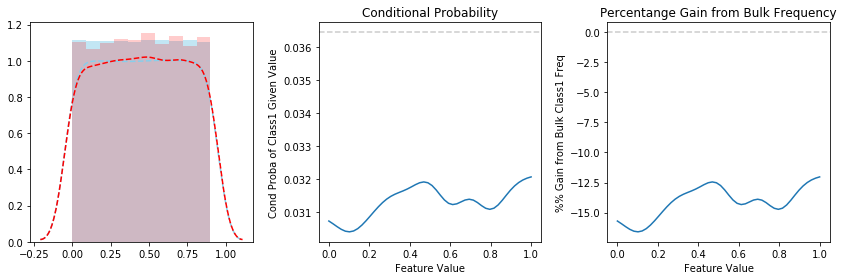

In [12]:
# ps_calc_01
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_calc_01'], target, np.linspace(0, 1, 50),
                              level=class1_freq, kernel='gau', bw=0.07, fft=True, hist_bins=10)

This is obviously not really gaussian and more like uniform. In any case, the feature is prob not useful, so it can be discareded later

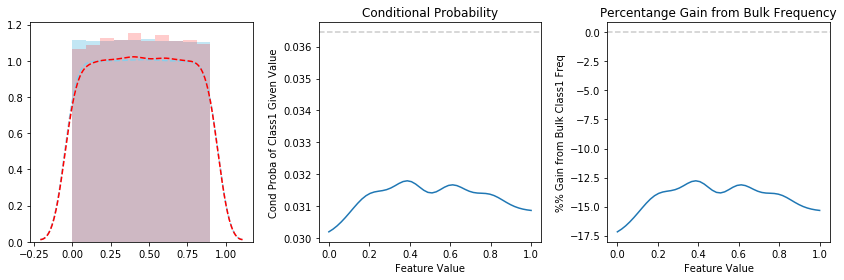

In [13]:
# ps_calc_02
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_calc_02'], target, np.linspace(0, 1, 50), 
                              level=class1_freq, kernel='gau', bw=0.07, hist_bins=10)

This is obviously not really gaussian and more like uniform. In any case, the feature is prob not useful, so it can be discareded later

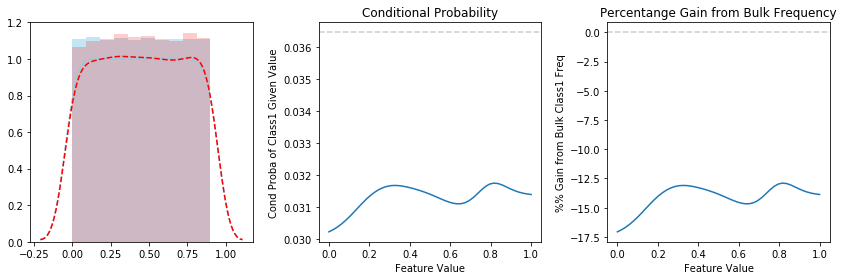

In [14]:
# ps_calc_03
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_calc_03'], target, np.linspace(0, 1, 50), 
                              level=class1_freq, kernel='gau', bw=0.07, hist_bins=10)

This is obviously not really gaussian and more like uniform. In any case, the feature is prob not useful, so it can be discareded later

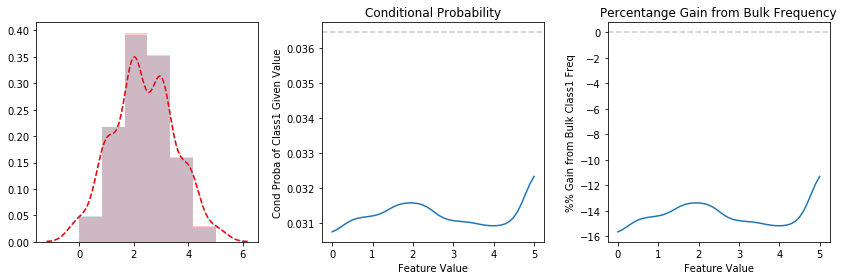

In [15]:
# ps_calc_04
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_calc_04'], target, np.linspace(0, 5, 50), 
                              level=class1_freq, kernel='gau', bw=0.4, hist_bins=6)

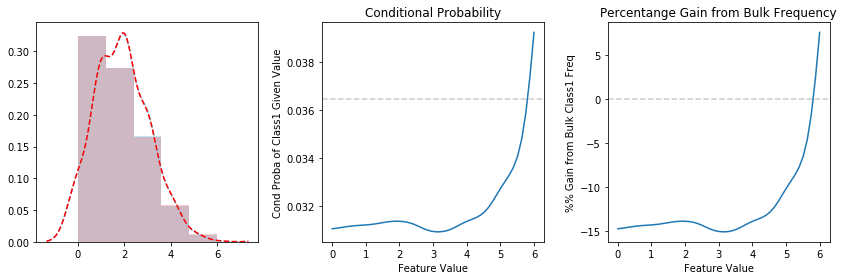

In [16]:
# ps_calc_05
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_calc_05'], target, np.linspace(0, 6, 50), 
                              level=class1_freq, kernel='gau', bw=0.45, hist_bins=5)

ps_calc_06: 11 unique vals:  [10  9  7  6  8  5  4  3  2  1  0]


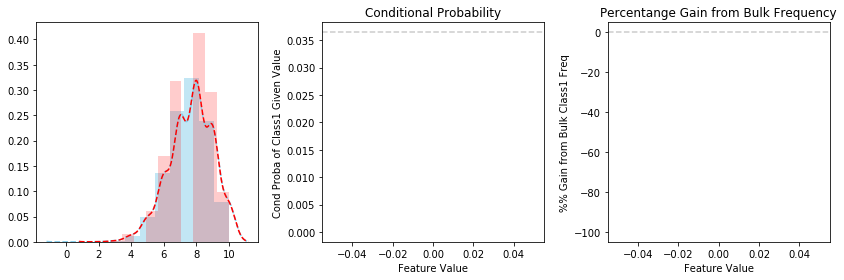

In [17]:
# ps_calc_06
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_calc_06'], target, np.linspace(0, 0, 50), 
                              level=class1_freq, kernel='gau', bw=0.4, hist_bins=11)
print('ps_calc_06: %d unique vals: ' % (len(ordinals['ps_calc_06'].unique())), ordinals['ps_calc_06'].unique())

ps_calc_07: 10 unique vals:  [1 5 3 2 4 6 0 7 8 9]


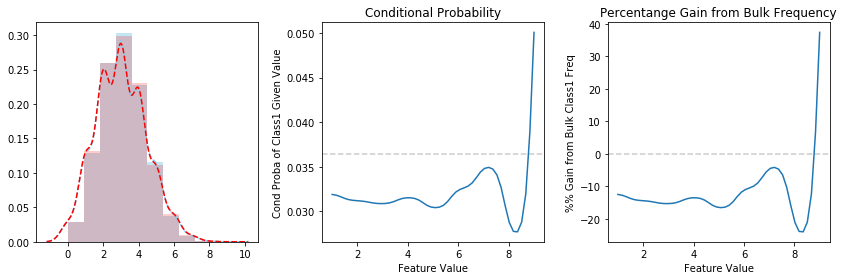

In [18]:
# ps_calc_07
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_calc_07'], target, np.linspace(1, 9, 50), 
                              level=class1_freq, kernel='gau', bw=0.4, hist_bins=10)
print('ps_calc_07: %d unique vals: ' % (len(ordinals['ps_calc_07'].unique())), ordinals['ps_calc_07'].unique())

ps_calc_08: 11 unique vals:  [10  8 11  6  9  7  5 12  4  3  2]


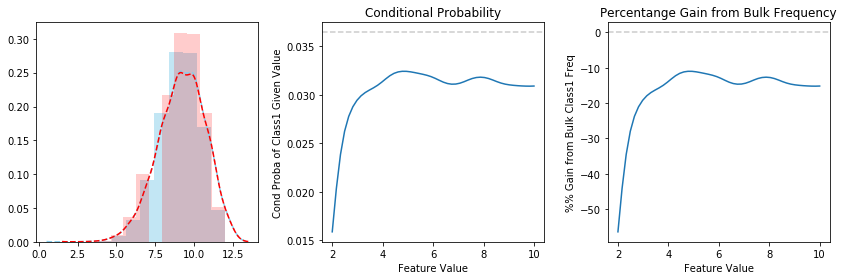

In [19]:
# ps_calc_08
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_calc_08'], target, np.linspace(2, 10, 50), 
                              level=class1_freq, kernel='gau', bw=0.5, hist_bins=11)
print('ps_calc_08: %d unique vals: ' % (len(ordinals['ps_calc_08'].unique())), ordinals['ps_calc_08'].unique())

ps_calc_09: 8 unique vals:  [1 2 4 3 0 5 6 7]


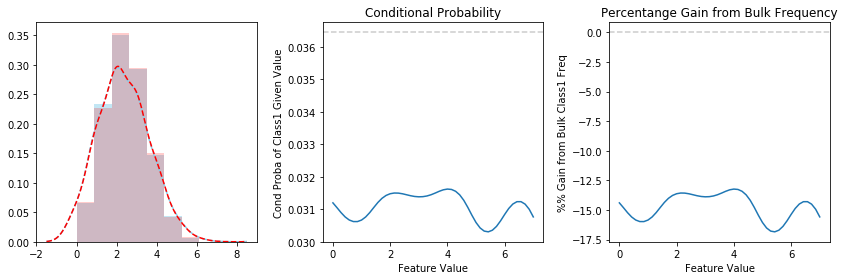

In [20]:
# ps_calc_09
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_calc_09'], target, np.linspace(0, 7, 50), 
                              level=class1_freq, kernel='gau', bw=0.5, hist_bins=8)
print('ps_calc_09: %d unique vals: ' % (len(ordinals['ps_calc_09'].unique())), ordinals['ps_calc_09'].unique())

ps_calc_10: 26 unique vals:  [ 5  7  2 12  8 10 13 11  9 18  4 15  6 14 16  3  1 17  0 21 19 20 22 23 25
 24]


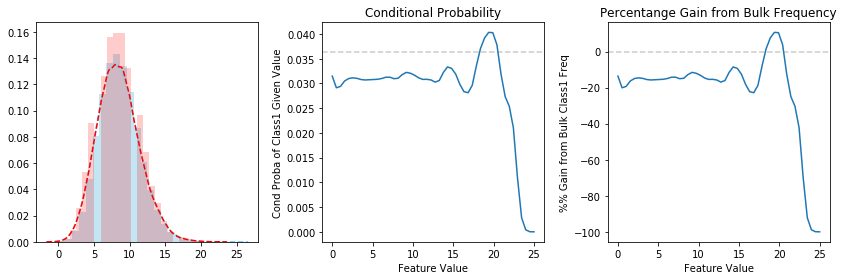

In [21]:
# ps_calc_10
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_calc_10'], target, np.linspace(0, 25, 50), 
                              level=class1_freq, kernel='gau', bw=0.55, hist_bins=26)
print('ps_calc_10: %d unique vals: ' % (len(ordinals['ps_calc_10'].unique())), ordinals['ps_calc_10'].unique())

ps_calc_11: 20 unique vals:  [ 9  3  4  2  7  6  5 10  8  1  0 13 11 12 14 15 16 19 17 18]


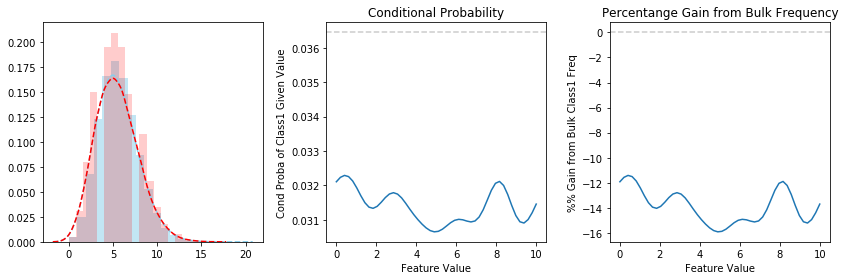

In [22]:
# ps_calc_11
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_calc_11'], target, np.linspace(0, 10, 50), 
                              level=class1_freq, kernel='gau', bw=0.6, hist_bins=20)
print('ps_calc_11: %d unique vals: ' % (len(ordinals['ps_calc_11'].unique())), ordinals['ps_calc_11'].unique())

ps_calc_12: 11 unique vals:  [ 1  2  0  5  3  4  6  7  8  9 10]


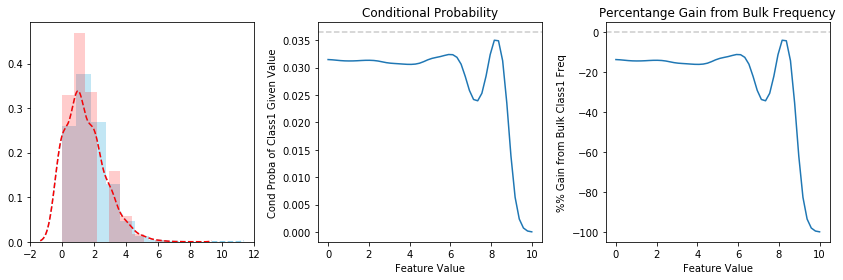

In [23]:
# ps_calc_12
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_calc_12'], target, np.linspace(0, 10, 50), 
                              level=class1_freq, kernel='gau', bw=0.45, hist_bins=11)
print('ps_calc_12: %d unique vals: ' % (len(ordinals['ps_calc_12'].unique())), ordinals['ps_calc_12'].unique())

ps_calc_13: 14 unique vals:  [ 5  1  7  4  0  3  6  2  8 10  9 11 12 13]


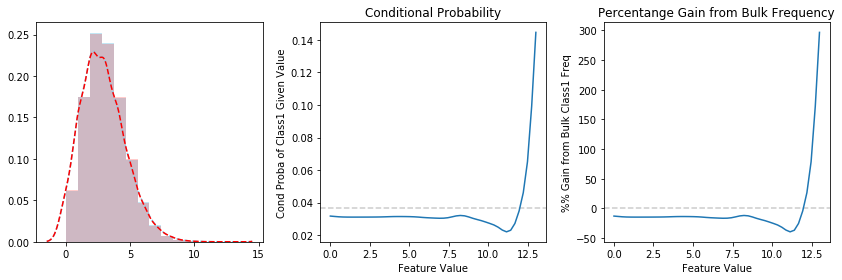

In [24]:
# ps_calc_13
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_calc_13'], target, np.linspace(0, 13, 50), 
                              level=class1_freq, kernel='gau', bw=0.5, hist_bins=14)
print('ps_calc_13: %d unique vals: ' % (len(ordinals['ps_calc_13'].unique())), ordinals['ps_calc_13'].unique())

ps_calc_14: 24 unique vals:  [ 8  9  7  3 10  6  5 11  4 14 13 12 16  2  1 15 17  0 19 20 18 22 21 23]


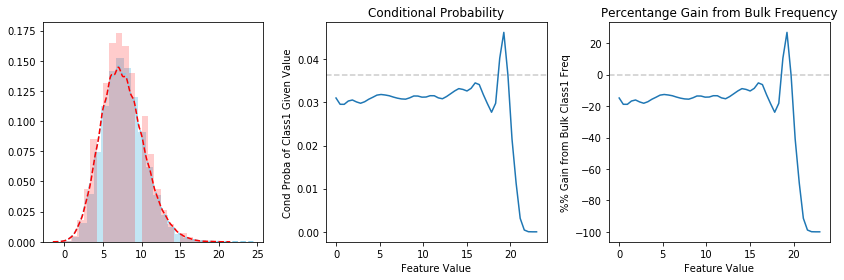

In [25]:
# ps_calc_14
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_calc_14'], target, np.linspace(0, 23, 50), 
                              level=class1_freq, kernel='gau', bw=0.5, hist_bins=24)
print('ps_calc_14: %d unique vals: ' % (len(ordinals['ps_calc_14'].unique())), ordinals['ps_calc_14'].unique())

ps_car_11: 5 unique vals:  [ 2  3  1  0 -1]


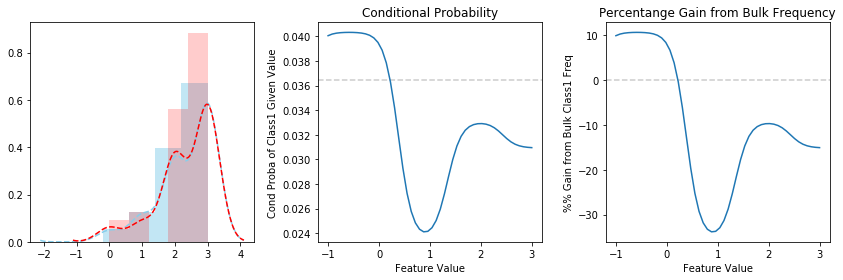

In [26]:
# ps_car_11
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_car_11'], target, np.linspace(-1, 3, 50), 
                              level=class1_freq, kernel='gau', bw=0.37, hist_bins=5)
print('ps_car_11: %d unique vals: ' % (len(ordinals['ps_car_11'].unique())), ordinals['ps_car_11'].unique())

ps_ind_01: 8 unique vals:  [2 1 5 0 4 3 6 7]


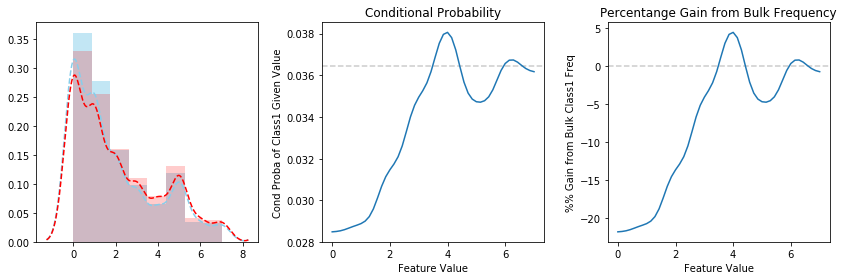

In [27]:
# ps_ind_01
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_ind_01'], target, np.linspace(0, 7, 50), 
                              level=class1_freq, kernel='gau', bw=0.42, hist_bins=8)
print('ps_ind_01: %d unique vals: ' % (len(ordinals['ps_ind_01'].unique())), ordinals['ps_ind_01'].unique())

ps_ind_03: 12 unique vals:  [ 5  7  9  2  0  4  3  1 11  6  8 10]


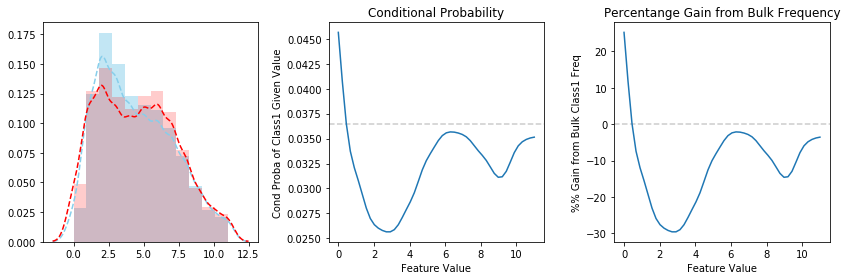

In [28]:
# ps_ind_03
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_ind_03'], target, np.linspace(0, 11, 50), 
                              level=class1_freq, kernel='gau', bw=0.5, hist_bins=12)
print('ps_ind_03: %d unique vals: ' % (len(ordinals['ps_ind_03'].unique())), ordinals['ps_ind_03'].unique())

ps_ind_14: 5 unique vals:  [0 1 2 3 4]


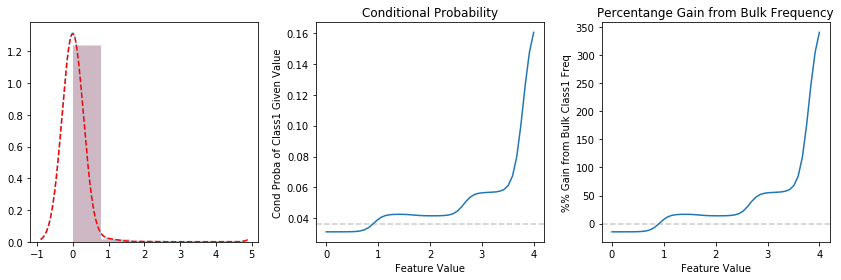

In [29]:
# ps_ind_14
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_ind_14'], target, np.linspace(0, 4, 50), 
                              level=class1_freq, kernel='gau', bw=0.3, hist_bins=5)
print('ps_ind_14: %d unique vals: ' % (len(ordinals['ps_ind_14'].unique())), ordinals['ps_ind_14'].unique())

ps_ind_15: 14 unique vals:  [11  3 12  8  9  6 13  4 10  5  7  2  0  1]


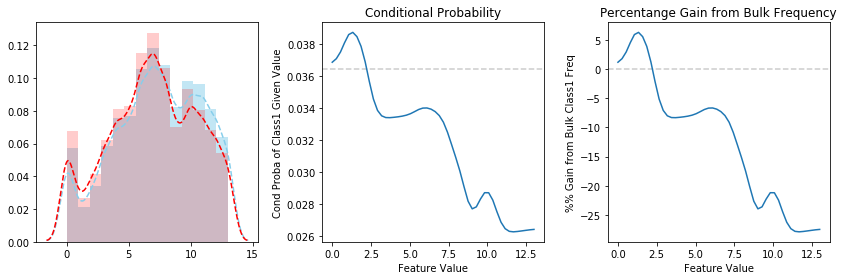

In [30]:
# ps_ind_15
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_ind_15'], target, np.linspace(0, 13, 50), 
                              level=class1_freq, kernel='gau', bw=0.55, hist_bins=14)
print('ps_ind_15: %d unique vals: ' % (len(ordinals['ps_ind_15'].unique())), ordinals['ps_ind_15'].unique())

ps_reg_01: 10 unique vals:  [ 0.7  0.8  0.   0.9  0.6  0.5  0.4  0.3  0.2  0.1]


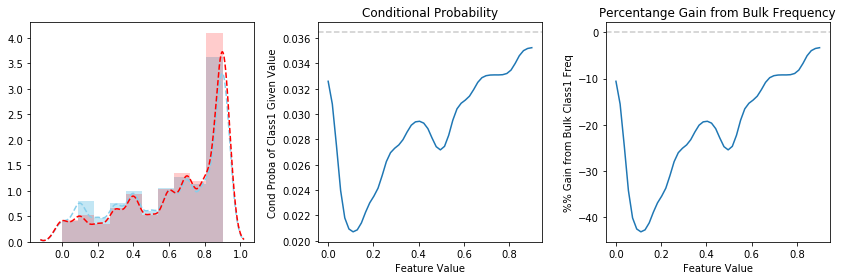

In [31]:
# ps_reg_01
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_reg_01'], target, np.linspace(0, 0.9, 50), 
                              level=class1_freq, kernel='gau', bw=0.04, hist_bins=10)
print('ps_reg_01: %d unique vals: ' % (len(ordinals['ps_reg_01'].unique())), ordinals['ps_reg_01'].unique())

ps_reg_02: 19 unique vals:  [ 0.2  0.4  0.   0.6  1.8  0.1  0.7  1.4  0.9  0.3  0.5  0.8  1.   1.3  1.6
  1.5  1.2  1.1  1.7]


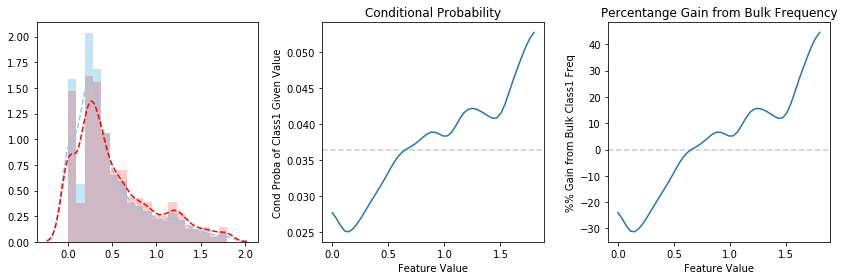

In [32]:
# ps_reg_02
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_reg_02'], target, np.linspace(0, 1.8, 50), 
                              level=class1_freq, kernel='gau', bw=0.08, hist_bins=19)
print('ps_reg_02: %d unique vals: ' % (len(ordinals['ps_reg_02'].unique())), ordinals['ps_reg_02'].unique())

## True continuous ones

ps_car_12: min & max: -1 to 1


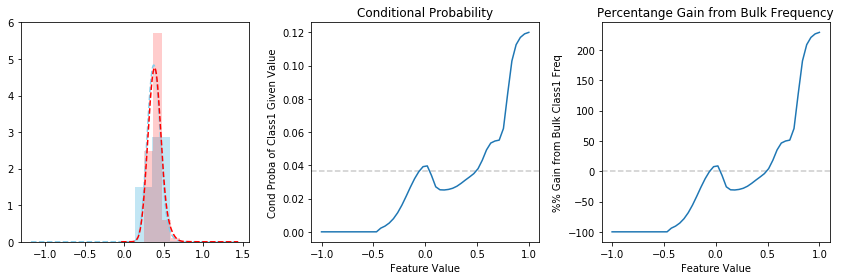

In [33]:
# ps_car_12
print('ps_car_12: min & max: %.f to %.f' % (np.min(conts['ps_car_12'].unique()), np.max(conts['ps_car_12'].unique())))
ps.myOrdinalFeatureAnalaysis1(conts['ps_car_12'], target, np.linspace(-1, 1, 50), 
                              level=class1_freq, kernel='gau', bw=0.06, hist_bins=10)

ps_car_13: min & max: 0 to 4


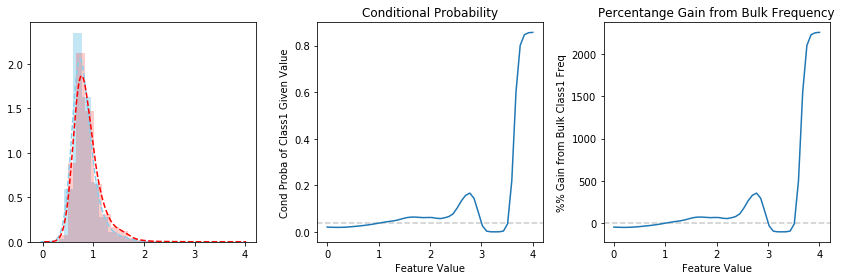

In [34]:
# ps_car_13
print('ps_car_13: min & max: %.f to %.f' % (np.min(conts['ps_car_13'].unique()), np.max(conts['ps_car_13'].unique())))
ps.myOrdinalFeatureAnalaysis1(conts['ps_car_13'], target, np.linspace(0, 4, 50), 
                              level=class1_freq, kernel='gau', bw=0.1, hist_bins=20)

ps_car_14: min & max: -1 to 1


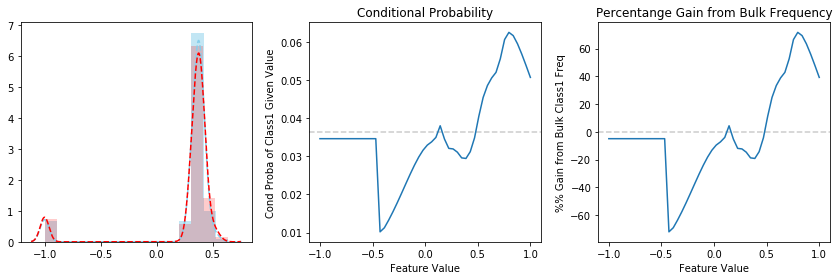

In [35]:
# ps_car_14
print('ps_car_14: min & max: %.f to %.f' % (np.min(conts['ps_car_14'].unique()), np.max(conts['ps_car_14'].unique())))
ps.myOrdinalFeatureAnalaysis1(conts['ps_car_14'], target, np.linspace(-1, 1, 50), 
                              level=class1_freq, kernel='gau', bw=0.04, hist_bins=15)

ps_car_15: min & max: 0 to 4


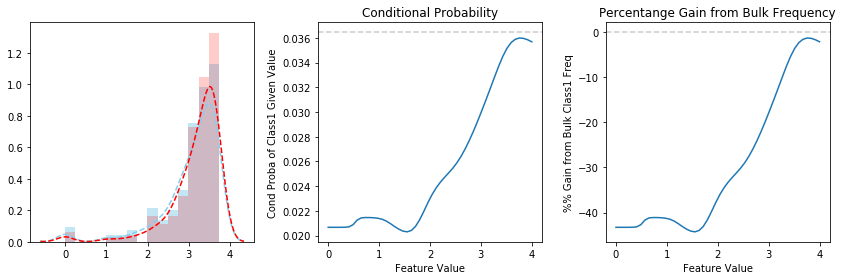

In [36]:
# ps_car_15
print('ps_car_15: min & max: %.f to %.f' % (np.min(conts['ps_car_15'].unique()), np.max(conts['ps_car_15'].unique())))
ps.myOrdinalFeatureAnalaysis1(conts['ps_car_15'], target, np.linspace(0, 4, 50), 
                              level=class1_freq, kernel='gau', bw=0.2, hist_bins=15)

ps_reg_03: min & max: -1 to 4


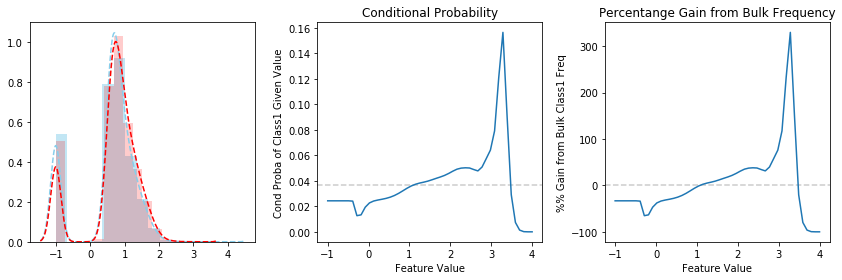

In [37]:
# ps_reg_03
print('ps_reg_03: min & max: %.f to %.f' % (np.min(conts['ps_reg_03'].unique()), np.max(conts['ps_reg_03'].unique())))
ps.myOrdinalFeatureAnalaysis1(conts['ps_reg_03'], target, np.linspace(-1, 4, 50), 
                              level=class1_freq, kernel='gau', bw=0.15, hist_bins=15)

## Testing methods/functions for feature space conversions

In [38]:
reload(fa)

<module 'feature_analysis' from '/home/ryohayama/python_current/porto_seguro/feature_analysis.py'>

In [39]:
reload(ps)

<module 'porto_seguro' from '/home/ryohayama/python_current/porto_seguro/porto_seguro.py'>

In [52]:
span = np.linspace(np.min(conts['ps_reg_03']), np.max(conts['ps_reg_03']), 500)

CPU times: user 5.68 s, sys: 1.23 s, total: 6.91 s
Wall time: 6.92 s


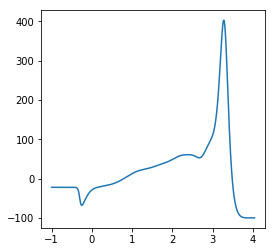

In [53]:
%%time
# use statsmodels version
kde_bulk = fa.OrdinalFeature(conts['ps_reg_03']).estimateKD(bw=0.15, graph=False, ax=None, hist_bins=10)

kde_class1 = fa.OrdinalFeature(conts['ps_reg_03'][target == 1]).estimateKD(bw=0.15, graph=False,
                                                                ax=None, hist_bins=10, alpha=0.2, color='red')

d1 = len(target)*kde_bulk.evaluate(np.array(span))
d2 = np.sum(target)*kde_class1.evaluate(np.array(span))
proba = d2/d1
g = 100*((proba/class1_freq) - 1)

plt.figure(figsize=(4, 4))
plt.plot(span, g)

CPU times: user 16.3 s, sys: 77.8 ms, total: 16.4 s
Wall time: 16.3 s


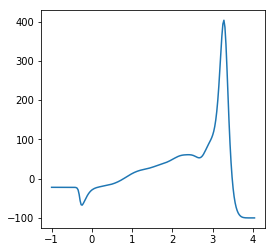

In [42]:
%%time
# use sklearn version
kde_bulk_sk = fa.OrdinalFeature(conts['ps_reg_03']).estimateKD2(bandwidth=0.15, graph=False, ax=None, hist_bins=10)

kde_class1_sk = fa.OrdinalFeature(conts['ps_reg_03'][target == 1]).estimateKD2(bandwidth=0.15, graph=False,
                                                                ax=None, hist_bins=10, alpha=0.2, color='red')

d1 = len(target)*np.exp(kde_bulk_sk.score_samples(np.array(span).reshape(-1, 1)))
d2 = np.sum(target)*np.exp(kde_class1_sk.score_samples(np.array(span).reshape(-1, 1)))
proba = d2/d1
g = 100*((proba/class1_freq) - 1)

plt.figure(figsize=(4, 4))
plt.plot(span, g)

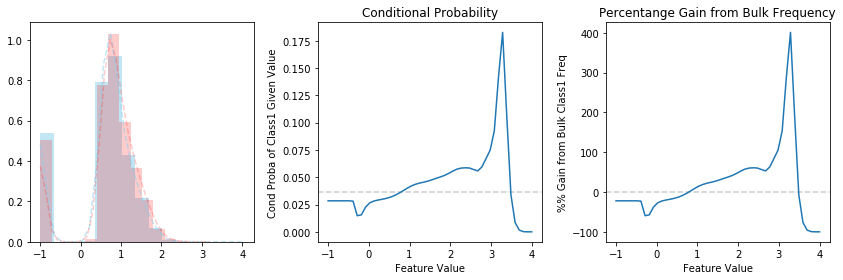

In [43]:
ps.myOrdinalFeatureAnalaysis2(conts['ps_reg_03'], target, np.linspace(-1, 4, 50), normed=True,
                              level=class1_freq, bandwidth=0.15, hist_bins=15)

In [44]:
reload(fa)

<module 'feature_analysis' from '/home/ryohayama/python_current/porto_seguro/feature_analysis.py'>

In [54]:
test_conversion = fa.OrdinalFeature(conts['ps_reg_03']).convertToGain(target, span, bw=0.15)

In [55]:
pd.concat([conts['ps_reg_03'], test_conversion], axis=1)

,ps_reg_03,0
0,0.718070,-4.396593
1,0.766078,-1.432602
2,-1.000000,-22.098194
3,0.580948,-10.821462
4,0.840759,3.009252
5,2.332649,60.688956
6,0.617454,-9.519332
7,0.607248,-9.965598
8,0.901388,6.890060
9,2.316652,60.623762


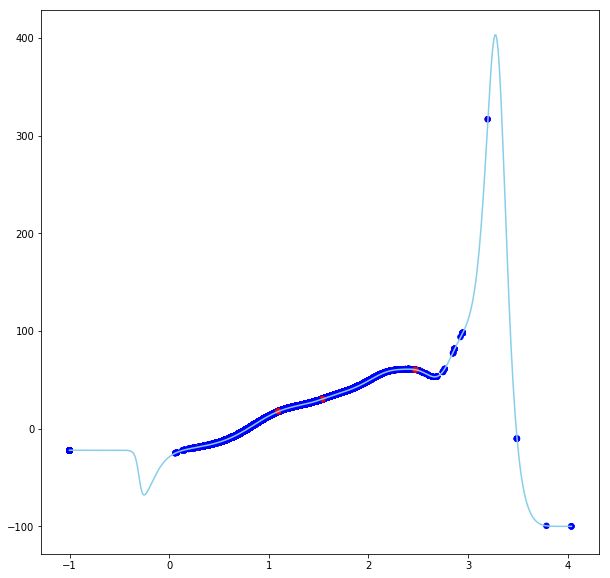

In [56]:
plt.figure(figsize=(10, 10))
plt.plot(span, g, color='skyblue')
plt.scatter(conts['ps_reg_03'], test_conversion, s=30, c=target, cmap=cm.bwr)

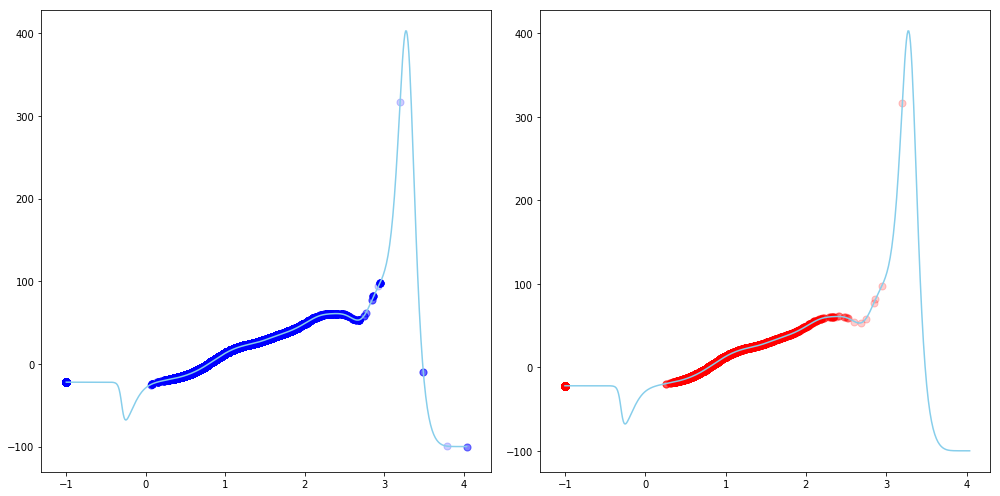

In [57]:
fog, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
ax1.plot(span, g, color='skyblue')
ax1.scatter(conts['ps_reg_03'][target == 0], test_conversion[target == 0], s=50, color='b', alpha=0.2)
ax2.plot(span, g, color='skyblue')
ax2.scatter(conts['ps_reg_03'][target == 1], test_conversion[target == 1], s=50, color='r', alpha=0.2)
plt.tight_layout()

This particular result is kind of strange. It may indicate this ratio thing may not be so useful after all...

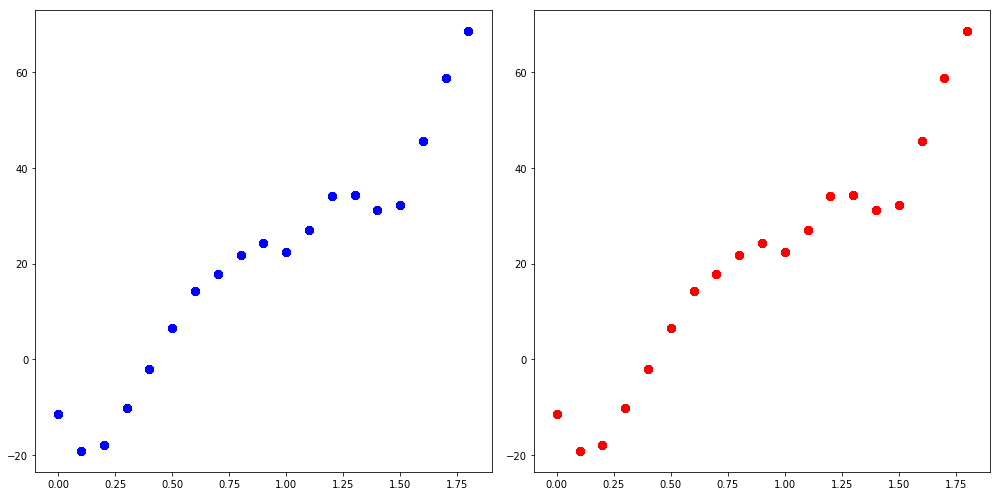

In [59]:
span2 = np.linspace(0, 1.8, 500)
test_conversion2 = fa.OrdinalFeature(ordinals['ps_reg_02']).convertToGain(target, span2, bw=0.08)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
ax1.scatter(ordinals['ps_reg_02'][target == 0], test_conversion2[target == 0], s=50, color='b', alpha=0.2)
ax1.scatter(ordinals['ps_reg_02'][target == 1], test_conversion2[target == 1], s=50, color='r', alpha=0.1)
ax2.scatter(ordinals['ps_reg_02'][target == 1], test_conversion2[target == 1], s=50, color='r', alpha=0.2)
plt.tight_layout()

## Comment
Looks like all the functions are working and now it's ready to be used. Create a dictionary for bw parameters and write a function that automates conversion of all the continuous/ordinal features using that bw_dict in the porto_seguro.py file.